<!--
---
title: Distributing raster calculations with tiles
layout: single
author: Heather Savoy
author_profile: true
header:
  overlay_color: "444444"
  overlay_image: /assets/images/margaret-weir-GZyjbLNOaFg-unsplash_dark.jpg
---
-->

**Last Update:** 29 September 2022 <br />
**Download Jupyter Notebook**: [GRWG22_RasterTiles.ipynb](https://geospatial.101workbook.org/tutorials/GRWG22_RasterTiles.ipynb)


## Overview
A common approach to distribute the workload in raster calculations is to split
a large raster into smaller 'tiles' or 'chunks'. This tutorial shows how to 
speed up a NDVI calculation by creating tiles and then distributing the tiles 
across cores. This process is not specific to calculating NDVI. You can use this
approach with any calculation that is performed per cell/pixel without depending
on the data in neighboring pixels (if neighboring data is needed, extra steps are 
involved).

In this tutorial, parallelization is performed within python using the resources 
allocated to the launched JupyterLab Server session. If you are interested in seeing
an example on how to submit your own SLURM job, please see 
[this tutorial](https://geospatial.101workbook.org/ExampleGeoWorkflows/GRWG22_ZonalStats_wSLURM_python).

*Language*: `Python`

*Primary Libraries/Packages*:

|Name|Description|Link|
|-|-|-|
| `rioxarray` | rasterio xarray extension | https://corteva.github.io/rioxarray/stable/readme.html |
| `rasterio` | access to geospatial raster data | https://rasterio.readthedocs.io/en/latest/ |
| `multiprocessing` | Process-based parallelism | https://docs.python.org/3/library/multiprocessing.html |
| `dask` | Scale the Python tools you love | https://www.dask.org |

## Nomenclature

* *Parallel processing:* Distributing computational tasks among multiple cores. 
* *Core:* A processor on a central processing unit; a physical or logical component 
  that can execute computational tasks. 
* *Tile (or chunk):* A continuous segment of a raster dataset or multi-dimensional 
  array.
* *NDVI:* Normalized Difference Vegetation Index, a quantity derived from the red
  and near-infrared bands of imagery to detect vegetation. 

## Analysis Steps
* Open Imagery and Setup Tiles - Open a GeoTIFF of Landsat 7 imagery and divide
  it into multiple smaller images.
* Define NDVI function - Write a function to calculate Normalized Difference 
  Vegetation Index from an image file.
* Compare serial versus parallel computation times - Measure the time it takes to
  perform the NDVI calculation across tiles in serial and in parallel
  * Option 1: using the `multiprocessing` package
  * Option 2: using `Dask`
* Visualize NDVI results - View the NDVI values in tiles as a whole image.

### Step 0: Import Libraries / Packages

Below are commands to run to create a new Conda environment named 'geoenv' that contains the packages used in this tutorial series. To learn more about using Conda environments on Ceres, see [this guide](https://scinet.usda.gov/guide/conda/). NOTE: If you have used other Geospatial Workbook tutorials from the SCINet Geospatial Research Working Group Workshop 2022, you may have aleady created this environment and may skip to launching JupyterHub.

First, we call `salloc` to be allocated resources on a compute node so we do not burden the login node with the conda installations. Then we load the `miniconda` conda module available on Ceres to access the `Conda` commands to create environments, activate them, and install Python and packages.

In [ ]:
salloc
module load miniconda
conda create --name geoenv
source activate geoenv
conda install geopandas rioxarray rasterstats plotnine ipython dask dask-jobqueue -c conda-forge

To have JupyterLab use this conda environment, we will make a kernel.

In [ ]:
ipython kernel install --user --name=geo_kernel

This tutorial assumes you are running this python notebook file in JupyterLab on 
Ceres. The easiest way to do that is with 
[Open OnDemand](http://ceres-ood.scinet.usda.gov/).  Select the following parameter 
values when requesting a Jupyter: Ceres app to be launched (all other 
values can be left to their defaults):

* `Slurm Partition`: short
* `Number of hours`: 1
* `Number of cores`: 16
* `Memory required`: 6G
* `Jupyer Notebook vs Lab`: Lab

Once you are in JupyterLab with this notebook open, select your kernel by clicking on the *Switch kernel* button in the top right corner of the editor. A pop-up will appear with a dropdown menu containing the *geo_kernel* kernel we made above. Click on the *geo_kernel* kernel and click the *Select* button. 

In [1]:
import time
import xarray
import rioxarray
import glob
import os
import rasterio
from rasterio.enums import Resampling
import multiprocessing as mp
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

#### Step 1a: Open imagery

The imagery file we will use is available from the `stars` R package. It is an 
example image from Landsat 7. In its documentation, it indicates that the first three bands are 
from the visible part of the electromagnetic spectrum (blue, green, red) and the 
fourth band in the near-infrared band. We can use `rioxarray`'s function `open_rasterio` to
read the imagery file. The `plot.imshow` function will let us visualize the image in
typical RGB. We can see that it is of a coast with forested areas that should 
have relatively high NDVI values. 


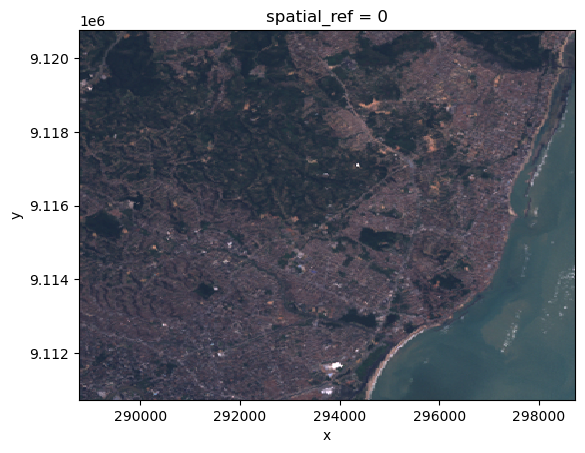

In [69]:
L7_ETMs = rioxarray.open_rasterio('L7_ETMs.tif').astype('int16')

# RGB Image using the third-first bands
L7_ETMs[[2,1,0]].plot.imshow()

This image is fairly small and we do not actually need to speed-up the NDVI 
calculation with parallel processing. So we will make it artificially a big data 
problem by disaggregating the pixels, i.e. making a greater number of smaller 
cells, for the sake of a portable example. The function `rio.reproject` accepts a 
raster object and a new shape, i.e. a new set of counts for rows and columns. Below, 
we are using a factor of 20 to disaggregate our raster which 
will create 400x pixels than the original. 

In [70]:
disagg_factor = 20
new_width = L7_ETMs.rio.width * disagg_factor
new_height = L7_ETMs.rio.height * disagg_factor

nir_red_fine = L7_ETMs[[2,3]].rio.reproject(
    L7_ETMs.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.nearest,
)

# Save to file
nir_red_fine.rio.to_raster('nr_fine.tif')

#### Step 1b: Making tiles

First, we will specify how many tiles we want. This example
will use 4 tiles in each directions for a total of 16 tiles. Next, we will use
nested `for` loops to iterate through our rows and columns of tiles, subset
our fine-scale image to that region, and then write the tile to a file with 
the tile indices indicated in the filename.

In [71]:
num_tiles = [4,4]

tile_width = int(new_width/num_tiles[0])
tile_height = int(new_height/num_tiles[1])

for i in range(num_tiles[0]):
    for j in range(num_tiles[1]):
        nir_red_tile = nir_red_fine[:,(i*tile_width):((i+1)*tile_width),(j*tile_height):((j+1)*tile_height)]
        nir_red_tile.rio.to_raster('tile_{0}_{1}.tif'.format(i,j))

<a id='NDVI'></a>
### Step 2: Defining NDVI function

Next, we want to define a function that will calculate NDVI for the pixels in 
one tile. The function will accept a tile's filename, open that file with `rioxarray`,
calculate NDVI for the pixels, then write the resulting single-band raster to
a new file. 

In [72]:
def normalized_diff_r(fname):
  nr = rioxarray.open_rasterio(fname)
  NDVI_r = (nr[1] - nr[0])/(nr[1] + nr[0])
  NDVI_r.rio.to_raster('NDVI_' + fname)


<a id='serial'></a>
### Step 3: Comparing serial and parallel processing times

To have a baseline to which to compare how long the parallel approach takes, we
can first time the serial approach. The `time.time()` function provides 
basic time reporting capabilities and when called before and after a computation, we can
find the processing time as the difference in number of seconds. 

### Step 3a: `multiprocessing` 

#### Serial

For our serial approach, we will use a `for` loop to iterate over our tile files and 
call our `normalized_diff_r` function. 

In [73]:
tile_files = glob.glob('tile*.tif')
tile_files = [os.path.basename(t_f) for t_f in tile_files]

st = time.time()
for t_f in tile_files:
    normalized_diff_r(t_f)
    
et = time.time()
print('Processing time: {:.2f} seconds'.format(et - st))

Processing time: 4.11 seconds


#### Parallel

To modify the serial approach above, we can use the `multiprocessing` function
`Pool` to set how many cores we want to use (here, matching the number of tiles) 
and the `pool.map_async` function
to asynchonously execute `normalized_diff_r` for our tiles across those cores. 

In [57]:
st = time.time()
pool = mp.Pool(num_tiles[0]*num_tiles[1])
results = pool.map_async(normalized_diff_r, tile_files)
pool.close()    
pool.join()
et = time.time()

print('Processing time: {:.2f} seconds'.format(et - st))

Processing time: 1.90 seconds


### Step 4: Visualize results

We have processed each tile, so we can merge the results back and see our NDVI results.

In [ ]:
ndvi_files = ['NDVI_' + t_f for t_f in tile_files]
elements = []
for file in ndvi_files:
    elements.append(rioxarray.open_rasterio(file))

merged = xarray.combine_by_coords(elements).squeeze()

merged.plot.imshow(cmap='YlGn')

### Step 5: Parallel - Dask

Dask is an alternative approach to this problem. The package `rioxarray`, which we used to open our original raster, is a geospatial extension of `xarray`, a package for manipulating multi-dimensional arrays that also has built-in connections with [Dask, a flexible library for parallel computating in Python](https://docs.dask.org/en/stable/). We can use the `xarray`/`Dask` integration to have the tiling work done for us. 

First, we will tell Dask that we are on a cluster managed by SLURM and pass a few arguments to tell SLURM what kind of specification we need. 

In [14]:
cluster = SLURMCluster(cores=2, memory='30GB', queue='short', processes=1)

Since we may not need the same number of cores throughout our processing, or we are not quite 
sure what the optimal number of cores may be, we can take advantage of Dask's option to have 
an adaptive cluster. The code chunk below tells Dask to request from SLURM 1 to 16 jobs at 
a given time depending on what we request Dask to calculate. 

In [15]:
cluster.adapt(minimum_jobs=1, maximum_jobs=16)
client = Client(cluster)

To begin using Dask in our NDVI calculation, we will restart by opening our fine-resolution imagery with 
`rioxarray.open_rasterio`, but this time pass a value to the `chunks` argument. By indicating that we
want chunks, we are telling `xarray`/Dask to split up our multi-dimensional array (multi-band image) into
chunks, or tiles. If you are not sure how to define the size of your chunks, you can just pass `'auto'` like
below and Dask will determine the chunk sizes for you.

When you print the Dask array object information to screen, the chunk sizes (in shape and bytes) are 
displayed along with a visual of your multi-dimensional array shape and the typical `xarray` printed
information.

In [ ]:
L7_ETMs_fine = rioxarray.open_rasterio('nr_fine.tif', chunks= 'auto')
L7_ETMs_fine

So now we have our imagery open and our chunks defined, we can continue writing our code as 
we would operate on a typical `rioxarray` object. The key difference is that Dask arrays
defer computation until needed. So we can execute the line below to calculate NDVI for the
whole image, but only the instructions are stored - the actual calculation has not happened 
yet. We print the newly created object and see the Dask-format printed output indicating that
the result is now a single band, as we expect for NDVI. That is because Dask is keeping track
of how our multi-dimensional array *will* be modified. 

In [24]:
NDVI =  (L7_ETMs_fine[1] - L7_ETMs_fine[0])/(L7_ETMs_fine[1] + L7_ETMs_fine[0])
NDVI

<xarray.DataArray (y: 7040, x: 6980)>
dask.array<truediv, shape=(7040, 6980), dtype=float64, chunksize=(7040, 6980), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 2.888e+05 2.888e+05 ... 2.987e+05 2.987e+05
  * y            (y) float64 9.121e+06 9.121e+06 ... 9.111e+06 9.111e+06
    spatial_ref  int64 0

To have the actual calculation be performed, a function requiring the results needs to be called. This can be an explicit request, e.g. the `compute` function below, or implicit, e.g. plotting the array's values. Below, we request for our `NDVI` array to be computed and measure the processing time.

In [25]:
st = time.time()
NDVI.compute()
et = time.time()
print('Processing time: {:.2f} seconds'.format(et - st))

Processing time: 0.80 seconds


During the computation, you can check the SLURM queue by running the `squeue -u firstname.lastname` in a shell with your SCINet username and see the jobs Dask submits to perform the calculation. 

In [ ]:
NDVI.plot.imshow(cmap='YlGn')

### Continue to explore

Things you can change in this tutorial to see how it affects the difference in
processing time between serial and parallel (or the two parallel library 
options):

* The disaggregation factor
* The number of tiles
* The number of cores